In [2]:
from google.colab import drive
drive.mount('/content/drive' )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings
from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
import keras.backend as K

In [4]:
import cv2
import os
import numpy as np # linear algebra
from tqdm import tqdm
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
from sklearn.preprocessing import LabelBinarizer

In [5]:
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import os


<h2> Unzipping and Loading of Data

In [6]:
!unzip urdu\ numb.zip -d Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/4/246.jpg  
  inflating: Dataset/Train/4/247.jpg  
  inflating: Dataset/Train/4/248.jpg  
  inflating: Dataset/Train/4/249.jpg  
  inflating: Dataset/Train/4/25.jpg  
  inflating: Dataset/Train/4/250.jpg  
  inflating: Dataset/Train/4/251.jpg  
  inflating: Dataset/Train/4/252.jpg  
  inflating: Dataset/Train/4/253.jpg  
  inflating: Dataset/Train/4/254.jpg  
  inflating: Dataset/Train/4/255.jpg  
  inflating: Dataset/Train/4/256.jpg  
  inflating: Dataset/Train/4/257.jpg  
  inflating: Dataset/Train/4/258.jpg  
  inflating: Dataset/Train/4/259.jpg  
  inflating: Dataset/Train/4/26.bmp  
  inflating: Dataset/Train/4/260.jpg  
  inflating: Dataset/Train/4/261.jpg  
  inflating: Dataset/Train/4/262.jpg  
  inflating: Dataset/Train/4/263.jpg  
  inflating: Dataset/Train/4/264.jpg  
  inflating: Dataset/Train/4/265.jpg  
  inflating: Dataset/Train/4/266.jpg  
  inflating: Dataset/Train/4/267.jpg  
  inflating: Da

In [7]:
def load_labels(myDir):
    labels=[]
    fileList = glob.glob(myDir)
   
    for fname in fileList:
        curLabel = fname.split("/")
        # print(curLabel[2])
        labels.append(curLabel[2])
    return np.asarray(labels)
        

def load_data(myDir):
    fileList = glob.glob(myDir)
    data=[]   
    for fname in fileList:
      img1 = cv2.imread(fname)
      x = cv2.resize(img1,(32,32), interpolation = cv2.INTER_AREA)
      data.append(x)
    return data

In [8]:
import glob
myDir ="Dataset/*/*/*.*"
labels = load_labels(myDir)
data = load_data(myDir)
data = np.array(data, dtype='float32')/255.
data.shape


(9874, 32, 32, 3)

In [9]:
labels = np.array(labels)
labels

array(['9', '9', '9', ..., '0', '0', '0'], dtype='<U1')

In [10]:

labels = to_categorical(labels, 10)
labels.shape

(9874, 10)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=42)

<h2> Adaptive Learning Rate

In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

<h2> CBAM and Sequeeze & Excitation Block
 

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		
	

In [14]:
input_shape = x_train.shape[1:]
print(input_shape)

(32, 32, 3)


Set 'attention_module' to 'cbam_block' if one want to use Convolution Based Attention Module with Renset V2. Set 'attention_module' to 'se_block' to use Squeeze and Excitation block. And set 'attention_module' to 'None' if you want to use the ResNet V2 with original setting.

In [15]:
# Training parameters
batch_size = 128
epochs = 40
data_augmentation = False
num_classes = 10
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy
base_model = 'Resnet_V2'

# Choose what attention_module to use: cbam_block / se_block / None
attention_module = 'se_block'
model_type = base_model if attention_module==None else base_model+'_'+attention_module

In [16]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test_mean = np.mean(x_test, axis=0)
    x_test -= x_test_mean

<h2> ResNet V2

In [17]:
"""
ResNet v2
This is a revised implementation from Cifar10 ResNet example in Keras:
(https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
# from models.attention_module import attach_attention_module

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=10, attention_module=None):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            # attention_module
            if attention_module is not None:
                y = attach_attention_module(y, attention_module)
                
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

<h2> Compiling and Training Model

In [18]:
depth = 20 # For ResNet, specify the depth (e.g. ResNet20: depth=20)
model = resnet_v2(input_shape=input_shape, depth=depth, attention_module=attention_module)


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

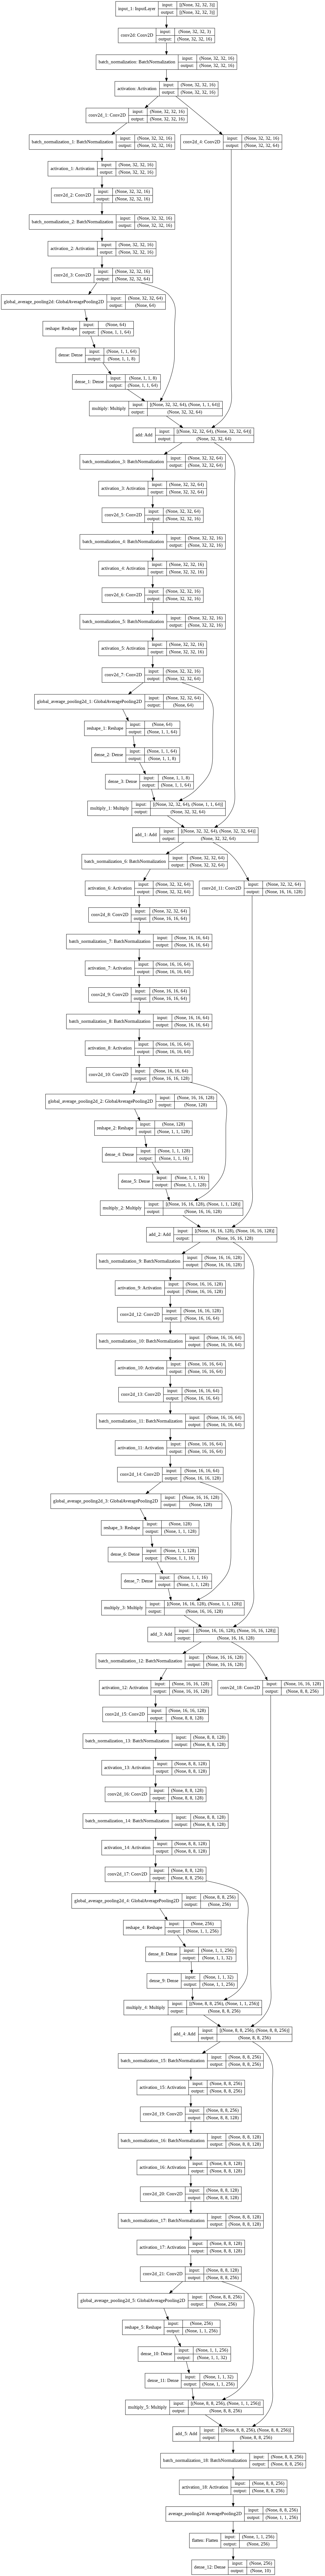

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
from keras.utils.vis_utils import plot_model
# print(model_type)
plot_model(model, to_file=model_type+'.png', show_shapes=True, show_layer_names=True)

Epoch 1/40
Learning rate:  0.001
52/52 [==============================] - 154s 3s/step - loss: 1.7597 - accuracy: 0.6088 - val_loss: 2.7802 - val_accuracy: 0.2326
Epoch 2/40
Learning rate:  0.001
52/52 [==============================] - 144s 3s/step - loss: 0.6130 - accuracy: 0.9413 - val_loss: 1.8925 - val_accuracy: 0.4937
Epoch 3/40
Learning rate:  0.001
52/52 [==============================] - 148s 3s/step - loss: 0.4876 - accuracy: 0.9767 - val_loss: 0.9323 - val_accuracy: 0.8303
Epoch 4/40
Learning rate:  0.001
52/52 [==============================] - 144s 3s/step - loss: 0.4455 - accuracy: 0.9824 - val_loss: 1.5238 - val_accuracy: 0.6324
Epoch 5/40
Learning rate:  0.001
52/52 [==============================] - 144s 3s/step - loss: 0.4076 - accuracy: 0.9886 - val_loss: 1.6646 - val_accuracy: 0.5511
Epoch 6/40
Learning rate:  0.001
52/52 [==============================] - 144s 3s/step - loss: 0.3883 - accuracy: 0.9899 - val_loss: 0.9012 - val_accuracy: 0.8193
Epoch 7/40
Learning ra

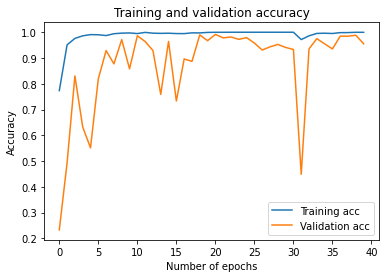

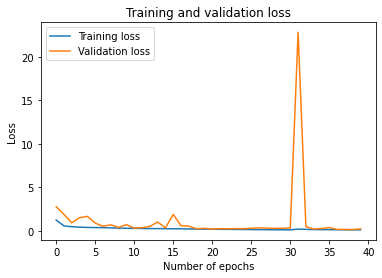

In [21]:

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'drive/MyDrive/CBAMProject/Resnet_v2/saved_models')
model_name = 'urdu_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks)

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))
# epochs = range(0, 85)

plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.savefig('drive/MyDrive/CBAMProject/Resnet_v2/saved_models/Acc_%s.{epoch:03d}.png', bbox_inches='tight')
plt.figure();

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('drive/MyDrive/CBAMProject/Resnext_none/saved_models/Loss_%s.{epoch:03d}.png', bbox_inches='tight')




<h2> Evaluationg Model




In [23]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


102/102 [==============================] - 19s 164ms/step - loss: 0.1546 - accuracy: 0.9920
Test loss: 0.15461884438991547
Test accuracy: 0.9920220971107483


<h2> Visualizing Feature Map

In [26]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('activation_27').output])

In [29]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
img = load_img('1.bmp', target_size=(32,32))

# convert img to array
img = img_to_array(img)

In [30]:
img.shape

(32, 32, 3)

In [31]:
from numpy import expand_dims

img = expand_dims(img, axis=0)
ouputs = model.predict(img)

model_outputs = ouputs[0]
attention_outputs = ouputs[1]

In [32]:
attention_outputs.shape

(1, 8, 8, 64)

In [33]:

feature_maps = model.predict(img)

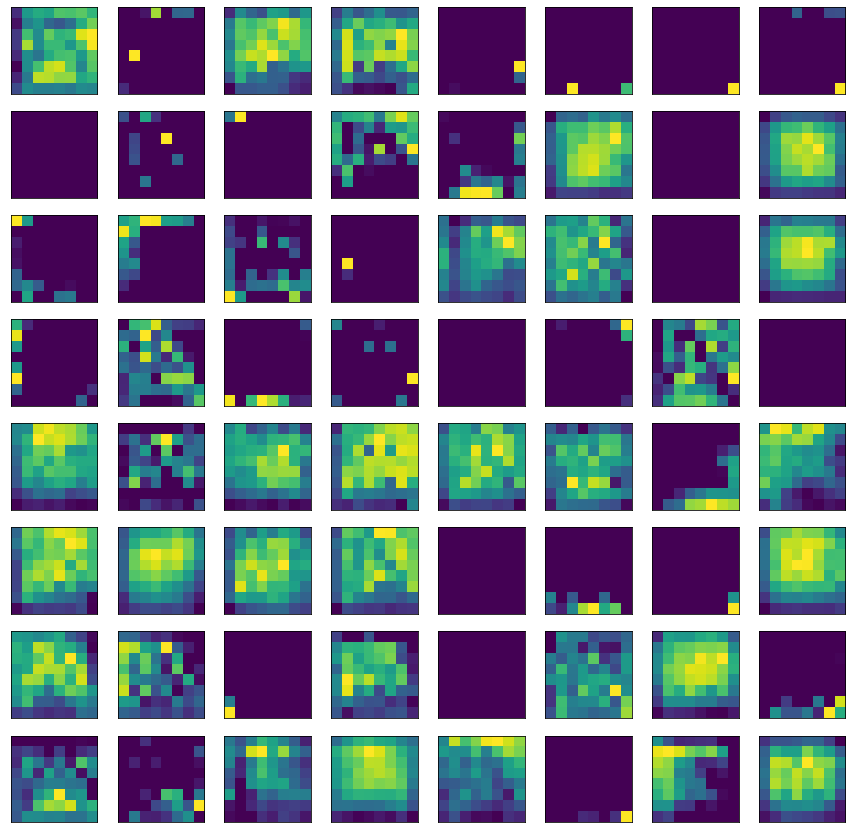

In [34]:
from matplotlib import pyplot
f = pyplot.figure()
f.set_size_inches(15,15)
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(attention_outputs[0, :, :, ix-1])
		ix += 1
# show the figure
pyplot.show()

<h2> Confusion Matrix and Classification Report

In [35]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from skimage import feature
from skimage import exposure
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd


In [36]:
predY = model.predict(x_test)

In [37]:
predY = predY[0].argmax(1)

In [38]:
y_test = y_test.argmax(1)

In [39]:

print(classification_report(y_test,predY, zero_division=0))
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test,predY)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       455
           1       1.00      0.98      0.99       446
           2       0.99      0.99      0.99       300
           3       1.00      1.00      1.00       336
           4       0.96      0.99      0.98       142
           5       1.00      1.00      1.00       223
           6       0.98      1.00      0.99       273
           7       1.00      0.99      1.00       305
           8       1.00      0.98      0.99       377
           9       1.00      1.00      1.00       402

    accuracy                           0.99      3259
   macro avg       0.99      0.99      0.99      3259
weighted avg       0.99      0.99      0.99      3259


Accuracy: 0.99



In [41]:
actual = pd.Series(y_test,name='Actual')
predicted = pd.Series(predY,name='Predicted')
confusion_matrix = pd.crosstab(actual, predicted, margins=True)

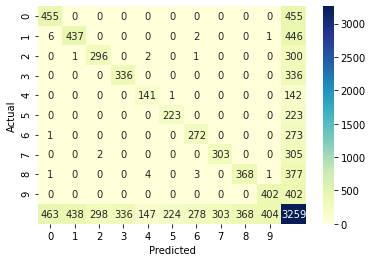

In [42]:
import seaborn as sns
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] # default sorting of classes is aplanumeric
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='d', cmap="YlGnBu")
